In [60]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
%matplotlib inline
from ggplot import *
import matplotlib.pyplot as plt

In [2]:
#read in train/test/valid
train = pd.read_csv('..\\partition\\train.csv')
valid = pd.read_csv('..\\partition\\valid.csv')
test = pd.read_csv('..\\partition\\test.csv')

In [3]:
#Split x and y for all sets
y_train = train.pop('over_50k')
y_valid = valid.pop('over_50k')
y_test = test.pop('over_50k')
x_train = train
x_valid = valid
x_test = test 

In [4]:
x_train.head()

,id,age,workclass_id,education_level_id,education_num,marital_status_id,occupation_id,race_id,sex_id,capital_gain,capital_loss,hours_week,country_id,workclass,education_level,marital_status,occupation,race,sex,country
0,11289,22,5,16,10,5,2,3,2,0,0,30,7,Private,Some-college,Never-married,Adm-clerical,Black,Male,Dominican-Republic
1,34529,43,8,11,16,3,11,5,1,0,0,40,40,State-gov,Doctorate,Married-civ-spouse,Prof-specialty,White,Female,United-States
2,28681,45,5,10,13,3,5,5,1,0,0,40,40,Private,Bachelors,Married-civ-spouse,Exec-managerial,White,Female,United-States
3,21496,41,5,12,9,3,4,5,2,0,0,45,40,Private,HS-grad,Married-civ-spouse,Craft-repair,White,Male,United-States
4,27291,56,5,12,9,3,5,5,2,0,0,40,40,Private,HS-grad,Married-civ-spouse,Exec-managerial,White,Male,United-States


### First stab at a logistic model with just numeric vars

In [5]:
#first stab with just numeric variables
x_num_train = x_train[["age","education_num","capital_gain","capital_loss", "hours_week",]]

In [20]:
x_num_train.head()

,age,education_num,capital_gain,capital_loss,hours_week
0,22,10,0,0,30
1,43,16,0,0,40
2,45,13,0,0,40
3,41,9,0,0,45
4,56,9,0,0,40


In [8]:
#Run a logistic regression on the numeric vars
logreg1 = LogisticRegression(C=1e20,tol=.00000001,max_iter=50)
#Other solvers too (e.g. sag, newton-cg, lbfgs)

#Fit log. model
logreg1.fit(x_num_train , y_train)

# Creating a coefficients table
coeff =  logreg1.coef_
pred_vars = list(x_num_train)
coeff_dict = dict(zip(pred_vars, *coeff))
print 'Numeric: age, education_num, capital_gain, capital_loss, hours_week'
print 'Categorical: none'
print 'Intercept: ', logreg1.intercept_   
pd.DataFrame(pd.Series(coeff_dict), columns=['coeff'])

Numeric: age, education_num, capital_gain, capital_loss, hours_week
Categorical: none
Intercept:  [-8.24093988]


,coeff
age,0.041274
capital_gain,0.000324
capital_loss,0.000688
education_num,0.324656
hours_week,0.039793


In [9]:
#Generate Probabilities for over_50k
probs1 = logreg1.predict_proba(x_num_train)
#Grab only over_50k
prob1 = probs1[:,1]
#Calculate and Print AUC
print "AUC:", metrics.roc_auc_score(y_train, prob1)

AUC: 0.830691071172


### Dummy the relevant categorical vars

In [10]:
# Race and Country are excluded as they don't appear important according to the exploratory analysis
# excluded education_level as it measures the same thing as education_num
# create dummy vars for marital_status, occupation, workclass, and sex 
m_dummies = pd.get_dummies(x_train['marital_status'])
o_dummies = pd.get_dummies(x_train['occupation'])
s_dummies = pd.get_dummies(x_train['sex'])
w_dummies = pd.get_dummies(x_train['workclass'])
x_train = x_train.join([m_dummies, o_dummies, s_dummies, w_dummies])

### Rank vars with RFE

In [12]:
#Recursive feature elimination on categorical vars

#just looking at the dummy vars
x_train_rfe = x_train.drop(['id','age','education_num','capital_gain','capital_loss', 'hours_week', 'workclass_id', 'education_level_id','marital_status_id', 'occupation_id','race_id','sex_id','country_id',
              'workclass','education_level', 'marital_status','occupation','race','country','sex'], axis=1)

In [14]:
features = list(x_train_rfe) 
#use logistic regression 
logr = LogisticRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(logr, n_features_to_select=1)
rfe.fit(x_train_rfe,y_train)
#match rankings to features and print
ranks = list(rfe.ranking_)
rankings = pd.DataFrame(
    {'feature': features,
     'rank': ranks,
    })
print rankings.sort(['rank'])
# Looks like this confirms the exploratory analysis
# Marital_status and Occupation rank above sex and workclass
# But let's train on all 4 of them with the numeric vars to see performance

                  feature  rank
2      Married-civ-spouse     1
1       Married-AF-spouse     2
16         Prof-specialty     3
10        Exec-managerial     4
15        Priv-house-serv     5
14          Other-service     6
12      Handlers-cleaners     7
31            Without-pay     8
11        Farming-fishing     9
19           Tech-support    10
18                  Sales    11
4           Never-married    12
22                 Female    13
23                   Male    14
24            Federal-gov    15
28           Self-emp-inc    16
17        Protective-serv    17
13      Machine-op-inspct    18
21          occup unknown    19
5               Separated    20
3   Married-spouse-absent    21
0                Divorced    22
6                 Widowed    23
8            Armed-Forces    24
20       Transport-moving    25
9            Craft-repair    26
30              State-gov    27
29       Self-emp-not-inc    28
26           Never-worked    29
32          class unknown    30
7       

C:\Users\Doug\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


### Logistic model (with categorical vars included)

In [36]:
# Logistic Model with age, education_num, capital_gain, capital_loss, hours_week, marital_status, occupation, sex, workclass

#create a full list of vars to be trained
full_vars = ['age','education_num','capital_gain','capital_loss', 'hours_week','Divorced','Married-AF-spouse',
            'Married-civ-spouse','Married-spouse-absent','Never-married','Separated','Widowed','occup unknown','Adm-clerical',
            'Armed-Forces','Craft-repair','Exec-managerial','Farming-fishing','Handlers-cleaners','Machine-op-inspct',
            'Other-service','Priv-house-serv','Prof-specialty','Protective-serv','Sales','Tech-support','Transport-moving',
            'Female','Male','Federal-gov','Local-gov','Never-worked','Private','Self-emp-inc','Self-emp-not-inc','State-gov',
            'Without-pay','class unknown']

# create data frame with continuous and dummy vars for occupation and marital status
x_train_full = x_train[full]

In [37]:
x_train_full.head()

,age,education_num,capital_gain,capital_loss,hours_week,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,...,Male,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,class unknown
0,22,10,0,0,30,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,43,16,0,0,40,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,45,13,0,0,40,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,41,9,0,0,45,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,56,9,0,0,40,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [48]:
#run logistic model
logreg_train_full = LogisticRegression(C=1e20,tol=.00000001,max_iter=50)
#Fit logistic model
logreg_train_full.fit(x_train_full , y_train)

LogisticRegression(C=1e+20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-08,
          verbose=0, warm_start=False)

In [49]:
# prettifying the parameters/coefficients table
coeff =  logreg_train_full.coef_
pred_vars = list(x_train_full)
coeff_dict = dict(zip(pred_vars, *coeff))
full_coeff = pd.DataFrame(pd.Series(coeff_dict), columns=['coeff'])

#Generate Probabilities for over_50k
probs_train_full = logreg_train_full.predict_proba(x_train_full)[:,1]

#printing notes and coeff dataframe
print "AUC:", metrics.roc_auc_score(y_train, probs_train_full)
print 'Numeric: age, education_num, capital_gain, capital_loss, hours_week'
print 'Categorical: martital_status, occupation, sex, workclass'  
print 'No. of Parameters:', len(full_coeff)
print 'Intercept: ', logreg_train_full.intercept_
full_coeff

AUC: 0.906941526364
Numeric: age, education_num, capital_gain, capital_loss, hours_week
Categorical: martital_status, occupation, sex, workclass
No. of Parameters: 38
Intercept:  [-4.82915244]


,coeff
Adm-clerical,-0.043823
Armed-Forces,0.435466
Craft-repair,-0.003565
Divorced,-1.336547
Exec-managerial,0.761830
Farming-fishing,-1.167260
Federal-gov,0.967042
Female,-2.462066
Handlers-cleaners,-0.928992
Local-gov,0.373958


In [40]:
#VALIDATION
# creating and joining dummy vars for marital_status and occupation
m_dummies = pd.get_dummies(x_valid['marital_status'])
o_dummies = pd.get_dummies(x_valid['occupation'])
s_dummies = pd.get_dummies(x_valid['sex'])
w_dummies = pd.get_dummies(x_valid['workclass'])
x_valid = x_valid.join([m_dummies, o_dummies, s_dummies, w_dummies])

In [41]:
# create data frame with same vars validation set
x_valid_full = x_valid[full]

In [50]:
#run logistic model on validaton
logreg_valid_full = LogisticRegression(C=1e20,tol=.00000001,max_iter=50)
#Fit logistic model
logreg_valid_full.fit(x_valid_full , y_valid)

LogisticRegression(C=1e+20, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=50, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=1e-08,
          verbose=0, warm_start=False)

In [51]:
# prettifying the parameters/coefficients table
coeff =  logreg_valid_full.coef_
pred_vars = list(x_valid_full)
coeff_dict = dict(zip(pred_vars, *coeff))
full_coeff_valid = pd.DataFrame(pd.Series(coeff_dict), columns=['coeff'])

#Generate Probabilities for over_50k
probs_valid_full = logreg_valid_full.predict_proba(x_valid_full)[:,1]

#printing AUC, notes and coeff dataframe
print "AUC:", metrics.roc_auc_score(y_valid, probs_valid_full)
print 'Numeric: age, education_num, capital_gain, capital_loss, hours_week'
print 'Categorical: martital_status, occupation, sex, workclass'  
print 'No. of Parameters:', len(full_coeff_valid)
print 'Intercept: ', logreg_valid_full.intercept_
full_coeff_valid

AUC: 0.900804524279
Numeric: age, education_num, capital_gain, capital_loss, hours_week
Categorical: martital_status, occupation, sex, workclass
No. of Parameters: 38
Intercept:  [-4.59746587]


,coeff
Adm-clerical,0.212323
Armed-Forces,-4.628093
Craft-repair,0.248522
Divorced,-1.215351
Exec-managerial,0.962270
Farming-fishing,-0.691641
Federal-gov,0.121130
Female,-2.379024
Handlers-cleaners,-0.344448
Local-gov,-0.710856


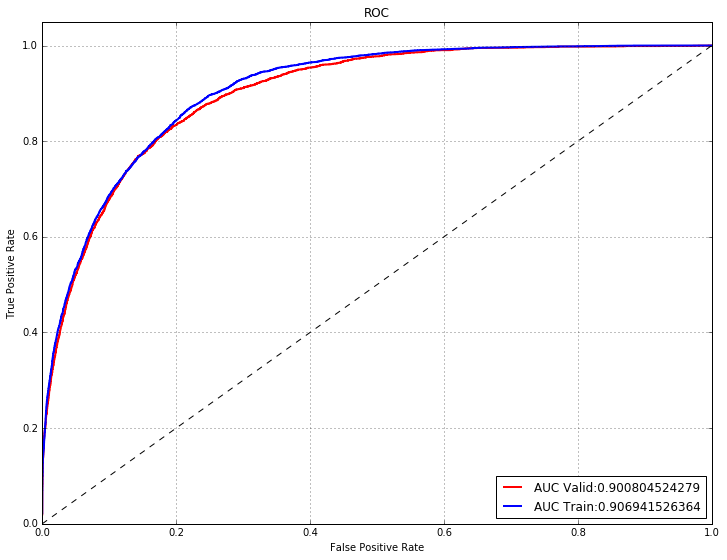

In [61]:
#Build ROC curve
#looks like it performs pretty well on validation

plt.figure(figsize=(12,9),dpi=600)

#the validation curve
fpr, tpr, thresholds = metrics.roc_curve(y_valid, probs_valid_full)
auc1 = auc(fpr,tpr)
plt.plot(fpr, tpr,label="AUC Valid:{0}".format(auc1),color='red', linewidth=2)

#the training curve
fpr, tpr, thresholds = roc_curve(y_train, probs_train_full)
auc1 = auc(fpr,tpr)
plt.plot(fpr, tpr,label="AUC Train:{0}".format(auc1),color='blue', linewidth=2)

#set axis limits
plt.plot([0, 1], [0, 1], 'k--', lw=1) 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05])

#labels
plt.xlabel('False Positive Rate')  
plt.ylabel('True Positive Rate') 
plt.title('ROC') 
plt.grid(True)
plt.legend(loc="lower right")

plt.show()